<a href="https://colab.research.google.com/github/haoliu0027/ALEXNET/blob/master/ALEXNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the dataset

In [1]:
! git clone https://github.com/haoliu0027/ALEXNET.git

fatal: destination path 'ALEXNET' already exists and is not an empty directory.


In [2]:
!ls
import os
os.chdir('ALEXNET')
!ls

ALEXNET  sample_data
ALEXNET  flower_data  README.md


In [3]:
!ls
from shutil import copy
import random


def mkfile(file):
    if not os.path.exists(file):
        os.makedirs(file)


file = 'flower_data/flower_photos'
os.listdir(file)
flower_class = [cla for cla in os.listdir(file) if ".txt" not in cla]
mkfile('flower_data/train')
for cla in flower_class:
    mkfile('flower_data/train/'+cla)

mkfile('flower_data/val')
for cla in flower_class:
    mkfile('flower_data/val/'+cla)

split_rate = 0.1
for cla in flower_class:
    cla_path = file + '/' + cla + '/'
    images = os.listdir(cla_path)
    num = len(images)
    eval_index = random.sample(images, k=int(num*split_rate))
    for index, image in enumerate(images):
        if image in eval_index:
            image_path = cla_path + image
            new_path = 'flower_data/val/' + cla
            copy(image_path, new_path)
        else:
            image_path = cla_path + image
            new_path = 'flower_data/train/' + cla
            copy(image_path, new_path)
        print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
    print()

print("processing done!")

ALEXNET  flower_data  README.md
[dandelion] processing [898/898]
[sunflowers] processing [699/699]
[roses] processing [641/641]
[daisy] processing [633/633]
[tulips] processing [799/799]
processing done!


In [0]:
import torch.nn as nn
import torch
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import json
import time
from PIL import Image

In [0]:
class AlexNet(nn.Module):
  def __init__(self, num_classes = 1000, init_weights = False):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2),  #input[3, 224, 224]  output[48, 55, 55]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2),       ## output[48, 27, 27]
        nn.Conv2d(48, 128, kernel_size=5, padding=2),          # output[128, 27, 27]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),               # output[128, 13, 13]
        nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),               # output[128, 6, 6]
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, start_dim=1)
      x = self.classifier(x)
      return x

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0)     

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

# data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
# image_path = data_root + "ALEXNET/flower_data/"  # flower data set path
! ls 

train_dataset = datasets.ImageFolder(root="flower_data/train", transform=data_transform["train"])
train_num = len(train_dataset)

# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root= "flower_data/val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=4, shuffle=True,
                                              num_workers=0)

# test_data_iter = iter(validate_loader)
# test_image, test_label = test_data_iter.next()
#
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
#
# print(' '.join('%5s' % cla_dict[test_label[j].item()] for j in range(4)))
# imshow(utils.make_grid(test_image))


net = AlexNet(num_classes=5, init_weights=True)

net.to(device)
loss_function = nn.CrossEntropyLoss()
# pata = list(net.parameters())
optimizer = optim.Adam(net.parameters(), lr=0.0002)

save_path = './AlexNet.pth'
best_acc = 0.0
for epoch in range(10):
    # train
    net.train()
    running_loss = 0.0
    t1 = time.perf_counter()
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print(time.perf_counter()-t1)

    # validate
    net.eval()
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
        for val_data in validate_loader:
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

cuda:0
ALEXNET  flower_data  README.md
train loss: 100%[**************************************************->]1.257
18.524198421000165
[epoch 1] train_loss: 1.347  test_accuracy: 0.483
train loss: 100%[**************************************************->]1.294
18.475027768000018
[epoch 2] train_loss: 1.179  test_accuracy: 0.538
train loss: 100%[**************************************************->]1.035
18.279473359999884
[epoch 3] train_loss: 1.090  test_accuracy: 0.585
train loss: 100%[**************************************************->]0.639
18.392857188000107
[epoch 4] train_loss: 1.007  test_accuracy: 0.652
train loss: 100%[**************************************************->]0.982
18.64149304600005
[epoch 5] train_loss: 0.964  test_accuracy: 0.687
train loss: 100%[**************************************************->]0.825
18.399049004000062
[epoch 6] train_loss: 0.921  test_accuracy: 0.691
train loss: 100%[**************************************************->]0.703
18.4958366669998

ALEXNET  AlexNet.pth  class_indices.json  flower_data  README.md
roses 0.5532703995704651


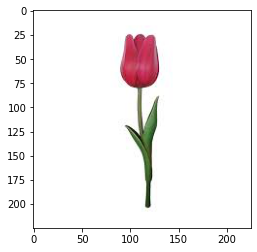

In [8]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
! ls
img = Image.open("flower_data/tulip.jpg")
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
try:
    json_file = open('./class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

# create model
model = AlexNet(num_classes=5)
# load model weights
model_weight_path = "./AlexNet.pth"
model.load_state_dict(torch.load(model_weight_path))
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img))
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()
print(class_indict[str(predict_cla)], predict[predict_cla].item())
plt.show()